# Works best when used with right handed pictures


In [1]:
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist

import copy
import argparse
import cv2 as cv
import numpy as np
import math
import imutils
%matplotlib inline

In [2]:
# get the path to the image

#img_path = './images/Image (17).jpg' #right handed
#img_path = './images/Image (16).jpg' #right handed
#img_path = './images/Image (15).jpg' #right handed
#img_path = './images/Image (11).jpg' #right handed
#img_path = './images/Image (2).jpg' #left handed
#img_path = './images/Image (3).jpg' #left handed
#img_path = './images/Image (14).jpg' #right handed
img_path = './images/Image (13).jpg' #right handed
#img_path = './images/Image (4).jpg' #left handed

img = cv.imread(img_path)

print('Original Dimensions : ',img.shape)
if img.shape[1] > 1700:
    width = 1700
    height = 2331
    dim = (width, height)
    # resize image
    resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
    img = resized
    print('Resized Dimensions : ',resized.shape)

plt.rcParams["figure.figsize"] = (16, 9)

Original Dimensions :  (2338, 1700, 3)


In [3]:
#This part is in use
def CalculateDistance(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2+(y2-y1)**2)

#This is not in use
#def CalcWidht(x1, y1, x2,y2):
#    m = (y2-y1)/(x2-x1)
#    c = y1-(m*x1)
#    print(m,c)
    
#    m2 = (y4-y3)/(x4-x3)
#    c2 = y3-(m*x3)
#    print(m2,c2)
    
#    new_m = m - m2
#    new_c = c2 - c
    
#    x = new_c - c2 - c
    
#    y = m*x + c
    
#    return x,y

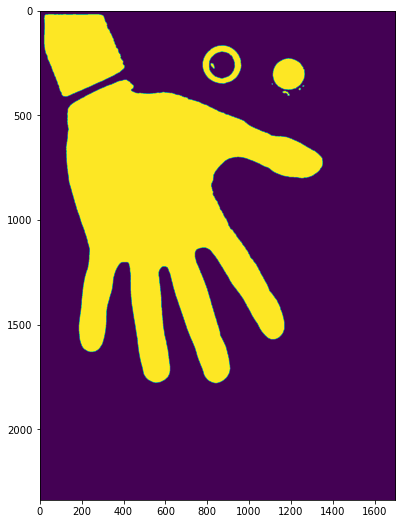

In [4]:
#this is for the hand
hsvim = cv.cvtColor(img, cv.COLOR_BGR2HSV)
lower = np.array([0, 40, 80], dtype = "uint8")
upper = np.array([250, 250, 250], dtype = "uint8")
skinRegionHSV = cv.inRange(hsvim, lower, upper)
blurred = cv.blur(skinRegionHSV, (10,10))
blurred = cv.medianBlur(blurred,3)
blurred = cv.GaussianBlur(blurred,(3,3), 0)

#this part is for coins
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = cv.GaussianBlur(gray, (5, 5), 0)
# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise

threshC = cv.threshold(gray, 45, 255, cv.THRESH_BINARY)[1]
threshC = cv.erode(threshC, None, iterations=5)
threshC = cv.dilate(threshC, None, iterations=8)

ret,thresh = cv.threshold(blurred,50,200,cv.THRESH_BINARY)
#ret,thresh = cv.threshold(blurred,127,255,cv.THRESH_BINARY | cv.THRESH_OTSU)
#ret,thresh = cv.threshold(blurred,50,200,cv.THRESH_TOZERO_INV | cv.THRESH_OTSU)

plt.imshow(thresh)
#plt.imshow(threshC)

In [5]:
#making hand black so coins are more clear
#contours, hierarchy = cv.findContours(threshC, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
#contours = max(contours, key=lambda x: cv.contourArea(x))
#cv.drawContours(img, [contours], -1, (0,0,0), -1)
#hull = cv.convexHull(contours)
#cv.drawContours(img, [hull], -1, (0,0,0), -1)
#print('done')

2
[95, 106]


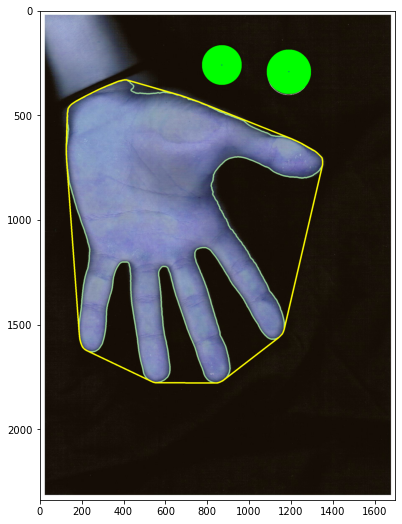

In [6]:
#Hough circle
circles = cv.HoughCircles(threshC, cv.HOUGH_GRADIENT, 0.001, 100,
                     param1=40, param2=20, minRadius=10, maxRadius=350)

circles = np.uint16(np.around(circles))
print(circles.shape[1])

radiusList = []
if circles is not None:
    for i in circles[0, :]:
        # draw the outer circle
        cv.circle(img, (i[0], i[1]), i[2], (0, 255, 0), -1)
        radiusList.append(i[2])       
        # draw the center of the circle
        cv.circle(img, (i[0], i[1]), 2, (0, 0, 255), -1)

print(radiusList)
        
#white line around hand, this is the line I calculate
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours = max(contours, key=lambda x: cv.contourArea(x))
cv.drawContours(img, [contours], -1, (255,255,255), 1)
#This is for looks
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours = max(contours, key=lambda x: cv.contourArea(x))
cv.drawContours(img, [contours], -1, (150,205,150), 5)



#yellow line connecting fingers
hull = cv.convexHull(contours)
cv.drawContours(img, [hull], -1, (255,255,0), 5)   
    
plt.imshow(img)

In [7]:
TwoEuroDiameter = 25.75 # in mm
OneEuroDiameter = 23.25 # in mm
OneEuro = min(radiusList) * 2.0
TwoEuro = max(radiusList) * 2.0
OnePixelLength = TwoEuroDiameter / TwoEuro
_OnePixelLength = OneEuroDiameter / OneEuro

sought = [255,255,255]
resultPixel = np.count_nonzero(np.all(img == sought, axis=2))/1
circumference2 = resultPixel * OnePixelLength #2euro
circumference1 = resultPixel * _OnePixelLength #1euro


In [8]:
img2 = img.copy()  

hull = cv.convexHull(contours, returnPoints=False)
defects = cv.convexityDefects(contours, hull)

dotCords = []
fingerTips = []

#print(len(contours))
if defects is not None:
    cnt = 0
    for i in range(defects.shape[0]):
        s, e, f, d = defects[i,0]
        start = tuple(contours[s][0])
        end = tuple(contours[e][0])
        far = tuple(contours[f][0])
        #print(f'start: {start} and end: {end}')
        dist = CalculateDistance(start[0],start[1],far[0],far[1])
        
        if dist > 300:
           
            length2 = dist * OnePixelLength
            length1 = dist * _OnePixelLength
            
            length2 = int(length2)
            length1 = int(length1)            
            
            cv.circle(img2, far, 20, [255, 255, 2], -1)# dot between palm and little finger
            dotCords.append(far)
            #print(f'length with 2 Euro: {length2} mm, length with 1 Euro: {length1}mm')
            
            #these lines are from dots between fingers to finger tips
            cv.line(img2, start, far, (255,0,0),5)
            cv.line(img2, end, far, (255,0,255),5)
            

        #Cosine theorem 
        a = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
        b = np.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
        c = np.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)
        angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))
        
        if angle <= np.pi / 2:  # angle less than 90 degree, treat as fingers
            c2 = cv.circle(img2, far, 20, [255, 255,  2], -1)#dots between fingers
            c2 = cv.circle(img2, end, 20, [255, 250,  2], -1)#dots on finger tips
            dotCords.append(far)
            fingerTips.append(end)
            cnt+=1        

#How many fingers are there to be found, displays on top of the picture
if cnt > 0:
    cnt = cnt+1
    #adds the number of fingers in the image
    cv.putText(img2, str(cnt), (1020, 2000), cv.FONT_HERSHEY_SIMPLEX,5, (255, 255, 255) , 10, cv.LINE_AA)  
    #adds string fingers in the image
    cv.putText(img2, 'fingers', (1140, 2000), cv.FONT_HERSHEY_SIMPLEX,5, (255, 255, 255) , 10, cv.LINE_AA)   
        
        
        
cv.line(img2, dotCords[0], dotCords[8], (20,255,150), (5))#this is for looks       
cv.line(img2, dotCords[0], dotCords[8], (2,255,15), (1))#this is what I calculate

sought2 = [2,255,15]
linePixel = np.count_nonzero(np.all(img2 == sought2, axis=2))/1
width2 = linePixel * OnePixelLength
width1 = linePixel * _OnePixelLength
print('done')
#plt.imshow(img2)

done


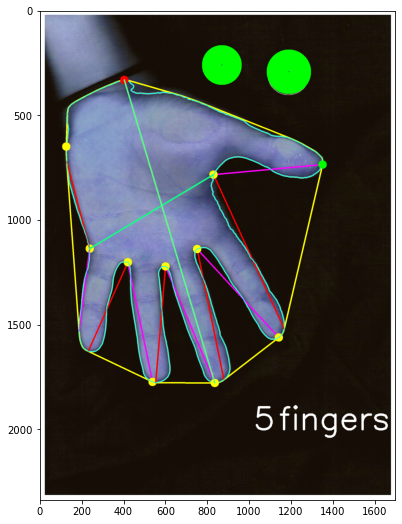

In [9]:
image = img2.copy()
extremePoints = []

cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL,
    cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv.contourArea)

# determine the most extreme points along the contour
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])
extremePoints.append(extTop)
extremePoints.append(extBot)

# draw the outline of the object, then draw each of the
# extreme points, where the left-most is red, right-most
# is green, top-most is blue, and bottom-most is teal
cv.drawContours(image, [c], -1, (0, 255, 255), 2)
cv.circle(image, extLeft, 20, (255, 255, 0), -1)#thumb
cv.circle(image, extRight, 20, (0, 255, 0), -1)
cv.circle(image, extTop, 20, (255, 0, 0), -1)
cv.circle(image, extBot, 20, (255, 255, 0), -1)



cv.line(image, extremePoints[0], extremePoints[1], (100,255,150), (5))#this is for looks
cv.line(image, extremePoints[0], extremePoints[1], (30,255,45), (1))#this is what I calculate
sought3 = [30,255,45]
linePixel = np.count_nonzero(np.all(image == sought3, axis=2))/1
height2 = linePixel * OnePixelLength
height1 = linePixel * _OnePixelLength

# show the output image
plt.imshow(image)

With 2euro 1 pixel lenght: 0.1214622641509434, counted pixels: 148406.0, circumference in mm: 18025.728773584906
With 1euro 1 pixel lenght: 0.12236842105263158, counted pixels: 148406.0, circumference in mm: 18160.207894736843

With 2euro widht in mm: 71.90566037735849
With 1euro widht in mm: 72.4421052631579

With 2euro height in mm: 175.7558962264151
With 1euro height in mm: 177.0671052631579

Diagnonal lenght between thumb and index finger using 2euro: 126.07783018867924 mm
Diagnonal lenght between thumb and index finger using 1euro: 127.01842105263158 mm

Diagnonal lenght between middle finger and index finger 2euro: 37.28891509433962 mm
Diagnonal lenght between middle finger and index finger 1euro: 37.5671052631579 mm

Diagnonal lenght between pinky and thumb 2euro: 148.79127358490567 mm
Diagnonal lenght between pinky and thumb 1euro: 149.9013157894737 mm


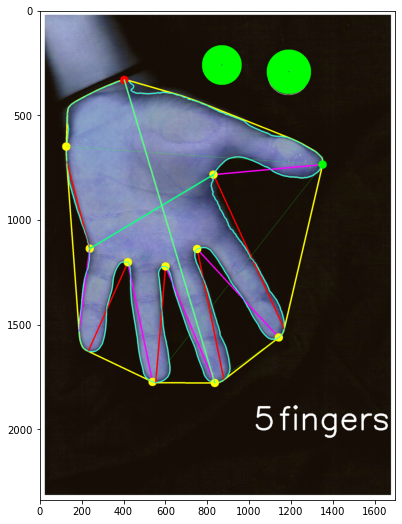

In [10]:
image2 = image.copy()

#cv.circle(image2,fingerTips[1],20,(255,255,255),-1)

cv.line(image2, fingerTips[0], fingerTips[3], (29,255,45), (1))
sought4 = [29,255,45]
linePixel1 = np.count_nonzero(np.all(image2 == sought4, axis=2))/1
thumbIndexMM1 = linePixel1 * OnePixelLength
thumbIndexMM2 = linePixel1 * _OnePixelLength

cv.line(image2, fingerTips[2], fingerTips[1], (36,251,47), (1))
sought5 = [36,251,47]
linePixel2 = np.count_nonzero(np.all(image2 == sought5, axis=2))/1
indexMiddleMM1 = linePixel2 * OnePixelLength
indexMiddleMM2 = linePixel2 * _OnePixelLength

cv.line(image2, extLeft, fingerTips[3], (31,255,45), (1))
sought6 = [31,255,45]
linePixel3 = np.count_nonzero(np.all(image2 == sought6, axis=2))/1
thumbPinkyMM1 = linePixel3 * OnePixelLength
thumbPinkyMM2 = linePixel3 * _OnePixelLength

print(f'With 2euro 1 pixel lenght: {OnePixelLength}, counted pixels: {resultPixel}, circumference in mm: {circumference2}')
print(f'With 1euro 1 pixel lenght: {_OnePixelLength}, counted pixels: {resultPixel}, circumference in mm: {circumference1}')
print()
print(f'With 2euro widht in mm: {width2}')
print(f'With 1euro widht in mm: {width1}')
print()
print(f'With 2euro height in mm: {height2}')
print(f'With 1euro height in mm: {height1}')
print()
print(f'Diagnonal lenght between thumb and index finger using 2euro: {thumbIndexMM1} mm')
print(f'Diagnonal lenght between thumb and index finger using 1euro: {thumbIndexMM2} mm')
print()
print(f'Diagnonal lenght between middle finger and index finger 2euro: {indexMiddleMM1} mm')
print(f'Diagnonal lenght between middle finger and index finger 1euro: {indexMiddleMM2} mm')
print()
print(f'Diagnonal lenght between pinky and thumb 2euro: {thumbPinkyMM1} mm')
print(f'Diagnonal lenght between pinky and thumb 1euro: {thumbPinkyMM2} mm')

plt.imshow(image2)

(2338, 1700)


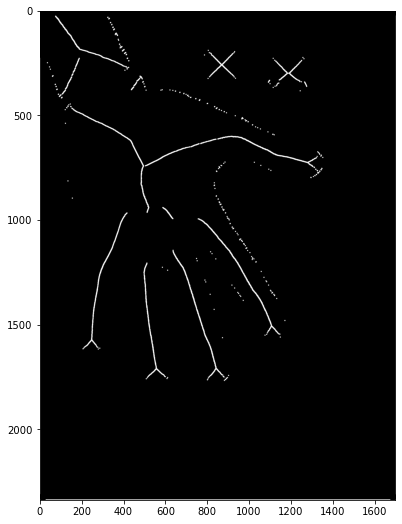

In [11]:
#Making a skeleton image of the hand, looks cool but does nothing

img3 = threshC.copy()

#thresh = cv.threshold(img3,127,255, cv.THRESH_BINARY)
ret,img3 = cv.threshold(img3, 127, 255, 0)
print(img3.shape)  

size = np.size(img3)
skel = np.zeros(img3.shape, np.uint8)

# Get a Cross Shaped Kernel
element = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))

# Repeat steps 2-4
while True:
    #Step 2: Open the image
    open = cv.morphologyEx(img3, cv.MORPH_OPEN, element)
    #Step 3: Substract open from the original image
    temp = cv.subtract(img3, open)
    #Step 4: Erode the original image and refine the skeleton
    eroded = cv.erode(img3, element)
    skel = cv.bitwise_or(skel,temp)
    img3 = eroded.copy()
    # Step 5: If there are no white pixels left ie.. the image has been completely eroded, quit the loop
    if cv.countNonZero(img3)==0:
        break
        
        

skel = cv.dilate(skel, None, iterations=2)  

#make copy to get color again
img4 = cv.cvtColor(skel, cv.COLOR_GRAY2BGR)

plt.imshow(img4)